In [1]:
# import the packages and setup the system

import numpy as np
import tensorflow as tf
import pandas as pd # though we won't need this very much
import matplotlib.pyplot as plt
import seaborn as sns

# set the datatype
tf.keras.backend.set_floatx('float32')

# initialize and set the constants for convenience
w = tf.constant(4,dtype='float32')
x_0 = tf.constant(10,dtype='float32')
x_dot_0 = tf.constant(0,dtype='float32')
pi = tf.constant(np.pi,dtype='float32')
c = tf.constant(0.1,dtype='float32')

# Define initial conditions
def fun_x_0(t):
  return tf.ones((t.shape[0],1),dtype='float32')*x_0

def fun_x_dot_0(t):
  return tf.ones((t.shape[0],1),dtype='float32')*x_dot_0

# Define the residual
def fun_r(t,x,x_t,x_tt):
  return x_tt+w*w*x+c*x_t

In [2]:

# Set the limits for t and x, Here we create two 1D tensors, ll and ul (lowerlimit and upper limit)
tmax = 6*pi
tmin = 0

ll = [tmin]
ul = [tmax]

# Set the random seed for reproducible results
tf.random.set_seed(0)

In [3]:
N_0 = 1
N_r = 30000

In [4]:
# Now its time to create datasets satisfying the boundary conditions

# INITIAL DATA
# u(0,x) = -sin(pi*x)
# t = 0 and x is sampled randomly with uniform distribution in range -1 to 1
t_0 = tf.zeros((N_0,1),dtype='float32')

# We can also evaluate the initial conditions for u: u(0,x)
X_0 = fun_x_0(t_0)
X_dot_0 = fun_x_dot_0(t_0)

# Collocation Points
# Both t and x arre drawn randomly with uniform distribution
t_r = tf.random.uniform((N_r,1),ll[0],ul[0],dtype='float32')

# We won't calculate the residual yet because we don't know the derivatives

In [5]:
## Lets setup the network architecture

def init__model(num_hiddenlayers=2,num_neurons_perlayer=40,act_fn='tanh'):
    model = tf.keras.Sequential()
    
    # Add input layer
    model.add(tf.keras.Input(1))
    
    # Add scalin layer
    scaling_layer = tf.keras.layers.Lambda(lambda t:2.0*(t-tmin)/(tmax-tmin)-1.0)
    model.add(scaling_layer)
    
    # Add the hidden layers
    for i in range(num_hiddenlayers):
        model.add(tf.keras.layers.Dense(num_neurons_perlayer,activation=
                                       act_fn,kernel_initializer='glorot_normal'))
    
    # Add output layer
    model.add(tf.keras.layers.Dense(1))
    
    return model

In [6]:
## Now we need to compute the residual for our loss function
# for that we need derivatives we use tf.Gradienttape

def get_loss(model,t_r,t_0,X_0,X_dot_0):

  with tf.GradientTape(persistent=True) as tape:

    tape.watch(t_r)

    # Find u (output of the model)
    x = model(t_r)
    x_t = tape.gradient(x,t_r)
    x_tt = tape.gradient(x_t,t_r)
  
  del tape
  with tf.GradientTape(persistent=True) as tape:

    tape.watch(t_0)

    # Find u (output of the model)
    x0 = model(t_0)
    x_t0 = tape.gradient(x0,t_0)
  
  del tape
  return tf.reduce_mean(tf.square(fun_r(t_r,x,x_t,x_tt))) + tf.reduce_mean(tf.square(x0-X_0)) + tf.reduce_mean(tf.square(x_t0-X_dot_0))

In [7]:
## To calculate the gradient with respect to parameters
def get_grad(model, t_r,t_0,X_0,X_dot_0):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = get_loss(model, t_r,t_0,X_0,X_dot_0)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

In [8]:
## Set up the optimizer and train the model

model = init__model()

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

In [9]:
# Train the model

from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, t_r,t_0,X_0,X_dot_0)
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    
    return loss

# Number of training epochs
N = 20000
hist = []

# Start timer
t0 = time()

for i in range(N+1):
    
    loss = train_step()
    
    # Append current loss to hist
    hist.append(loss.numpy())
    
    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))
        
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 1.23371902e+02
It 00050: loss = 9.76062851e+01
It 00100: loss = 9.61999054e+01
It 00150: loss = 9.54817123e+01
It 00200: loss = 9.45696564e+01
It 00250: loss = 9.16605377e+01
It 00300: loss = 8.85901489e+01
It 00350: loss = 8.53274765e+01
It 00400: loss = 8.22681808e+01
It 00450: loss = 7.75369873e+01
It 00500: loss = 7.00297241e+01
It 00550: loss = 6.43132095e+01
It 00600: loss = 6.00461769e+01
It 00650: loss = 5.84682388e+01
It 00700: loss = 5.44167976e+01
It 00750: loss = 5.17414703e+01
It 00800: loss = 4.95331573e+01
It 00850: loss = 4.77632446e+01
It 00900: loss = 4.62546425e+01
It 00950: loss = 4.53036728e+01
It 01000: loss = 4.41965981e+01
It 01050: loss = 4.35000153e+01
It 01100: loss = 4.33878136e+01
It 01150: loss = 4.32745743e+01
It 01200: loss = 4.31591797e+01
It 01250: loss = 4.30417328e+01
It 01300: loss = 4.29223137e+01
It 01350: loss = 4.28009415e+01
It 01400: loss = 4.26777306e+01
It 01450: loss = 4.25527153e+01
It 01500: loss = 4.24259377e+01
It 01550

In [15]:
t_r = tf.sort(t_r, axis=0)
t_r

<tf.Tensor: shape=(30000, 1), dtype=float32, numpy=
array([[1.6223645e-03],
       [2.5706163e-03],
       [4.6289070e-03],
       ...,
       [1.8848122e+01],
       [1.8848202e+01],
       [1.8848701e+01]], dtype=float32)>

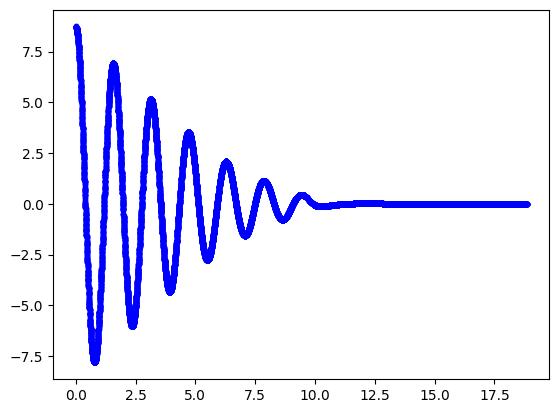

In [17]:

x_pred = model(t_r)
plt.plot(t_r,x_pred,marker='.',color='blue', linewidth=2)

plt.show()

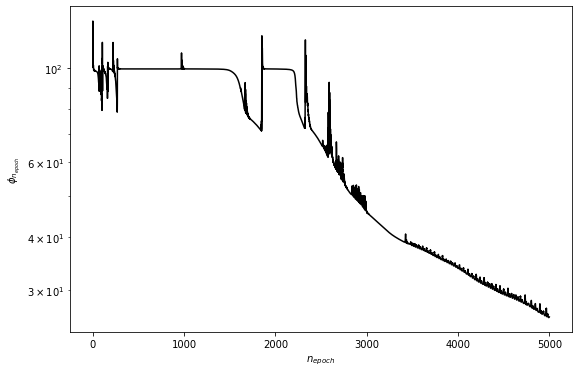

In [ ]:
## Plot the loss
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');